# Problem 2. Finding Neptune before seeing it.

https://en.wikipedia.org/wiki/Discovery_of_Neptune

The planet Neptune was mathematically predicted before it was directly observed. With a prediction by Urbain Le Verrier, telescopic observations confirming the existence of a major planet were made on the night of September 23–24, 1846, at the Berlin Observatory, by astronomer Johann Gottfried Galle (assisted by Heinrich Louis d'Arrest), working from Le Verrier's calculations. It was a sensational moment of 19th-century science, and dramatic confirmation of Newtonian gravitational theory. In François Arago's apt phrase, Le Verrier had discovered a planet "with the point of his pen".

In this home Problem, we are letting you to discover Neptune in a Sun-Uranus-Neptune system using `jax`. We will start with a single-planet practice



In [1]:
import numpy as onp
import jax.numpy as np
from jax.experimental.ode import build_odeint, odeint
from jax.experimental import optimizers
from jax import grad
from jax import jit
import matplotlib.pyplot as plt
import numpy as onp

## (a) Consider a two-body Uranus-Sun system. Suppose the Uranus' orbital around sun has a farthest point with $d_{US} = 0.25$. At this point, the Uranus travels at $v_U = 4$. Load the data from `orbit_data_2B.txt` and use `jax` to find out what is the mass of the Sun $m_S$.

The time period within which the data is simulated is between $0$ and $0.4$.
The recommended initial guess of the mass is somewhere from $0$ to $10$.

In [2]:
d_US = 0.25

The two-body Newton's equation of motion written in an `odeint` compatible form

In [3]:
# What is the coord part of this input? It worked with the real orbit_data. Also what is the output? With the 
# real orbit_data it output a 4x4 array
def newton_2(coord, t, m_S):
    x = coord[:2]
    y = coord[2:4]
    r = np.sqrt(x[0]**2+y[0]**2)
    ax = -(x[0]/r)*m_S/r**2
    ay = -(y[0]/r)*m_S/r**2
    return np.array([x[1], ax, y[1], ay])

Load the two-body data. The data is in the format of $(x, v_x, y, v_y)$ where $v$ is the velocity.

In [4]:
orbit_data = onp.loadtxt('./orbit_data_2B.txt')

This is how the orbit looks like

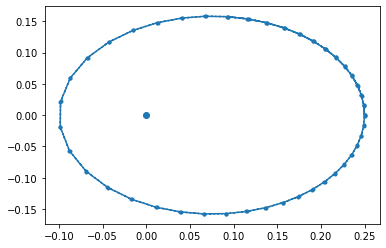

In [5]:
plt.plot(orbit_data[:,0],orbit_data[:,2],'.--')
plt.scatter([0],[0])
plt.show()

### Solution to (a)

In [6]:
# Get the odeint form of newton_2
newton_2_odeint = build_odeint(newton_2)

# Get the correct orbit and time vector
real_orbit = orbit_data
t = onp.linspace(0,0.4,100)


In [7]:
# Define the loss function
def loss_1(m_S_est):
    return np.sum((newton_2_odeint(real_orbit[0,:], t, m_S_est).reshape(-1)-real_orbit.reshape(-1))**2)


In [8]:
# Calculate the gradient w.r.t. m_S
m_S_grad = jit(grad(loss_1))

# Give an estimate for m_S
m_S_est = 9.0

# Define a learning rate
lr_m_S = 0.00001

# Perform the optimization
iter_count = 0
m_S_list = [m_S_est]
loss_1_list = [loss_1(m_S_est)]
while True:
    m_S_est -= lr_m_S * m_S_grad(m_S_est)
    m_S_list.append(m_S_est)
    loss_1_list.append(loss_1(m_S_est))
    iter_count += 1
    
    if onp.abs(m_S_list[-2]-m_S_list[-1]) < 10e-10 and onp.abs(loss_1_list[-2]-loss_1_list[-1]) < 10e-10:
        print("Converged on iteration", iter_count, "with m_S estimate", m_S_est)
        break
        
    elif iter_count > 10000:
        print("Failed to converge in 10000 iterations")
        break
        
    else: continue

/home/zack/anaconda3/envs/am216/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Converged on iteration 98 with m_S estimate 7.000003


In [9]:
test_orbit = newton_2_odeint(real_orbit[0,:], t, m_S_list[-1])

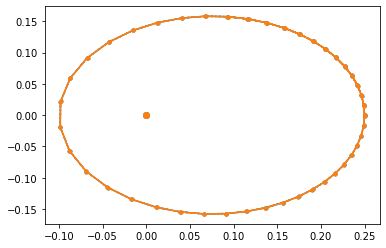

In [10]:
plt.plot(test_orbit[:,0],test_orbit[:,2],'.--')
plt.scatter([0],[0])
plt.plot(orbit_data[:,0],orbit_data[:,2],'.--')
plt.scatter([0],[0])
plt.show()

Looking at this plot of the estimated orbit overlayed with the real orbit, we can see that our m_S estimate is very good. Note that I tried this for several different initial conditions, and the many of them converged to non-optimal minima that led to very poor orbit estimates. 

## (b) Now we consider the three body system including the Sun, Uranus and Neptune. You will be given

*   A short trajectory of Uranus `orbit_data_3B.txt`. The time period within which the data is simulated is between $0$ and $0.05$.
*   Mass $m_U$. Distance from the Uranus to the Sun at the starting point $r_{U}$.

and you will predict
*   The mass of Neptune $m_N$
*   The distance from Neptune to the Sun at the starting point $r_{N}$

More configuration of the sustem:
*   The Sun is fixed at $(0,0)$
*   The starting positions of the Uranus and the Neptune are $(r_U, 0)$ and $(r_N, 0)$.
*   Uranus and Neptune are put quite close to each other in order for the influence between Uranus and Neptune to show up quickly.
*   In this question, the velocities are set to $\sqrt{M/r_0}$, which is the velocity of a circular orbital when feeling only the gravity from the sun. You can find it in the following code but you do not need to do any modification.

**Report your findings to Kaggle!**

The recommended initial guess of the mass is somewhere from $5$ to $15$.
The recommended initial guess of the orbit radius is somewhere from $2$ to $5$.

In [11]:
m_U = 8.681 
m_S = 7*10**4 
r_U = 1.784 

The two-body Newton's equation of motion written in an `odeint` compatible form

In [12]:
@jit
def grav(m1,m2,r):
    return m1*m2/r**2
@jit
def newton_3(coord, t, m_N, r_N):
    x_U = coord[:2] # x is actually x and dx/dt
    y_U = coord[2:4]
    x_N = coord[4:6]
    y_N = coord[6:8]
    r_U = np.sqrt(x_U[0]**2+y_U[0]**2)
    r_N = np.sqrt(x_N[0]**2+y_N[0]**2)
    x_UN = x_N - x_U
    y_UN = y_N - y_U    
    r_UN = np.sqrt((x_UN[0])**2+(y_UN[0])**2)
    
    fx_U = -(x_U[0]/r_U)*grav(m_U, m_S, r_U) + (x_UN[0]/r_UN)*grav(m_U, m_N, r_UN)
    fy_U = -(y_U[0]/r_U)*grav(m_U, m_S, r_U) + (y_UN[0]/r_UN)*grav(m_U, m_N, r_UN)    
    fx_N = -(x_N[0]/r_N)*grav(m_N, m_S, r_N) - (x_UN[0]/r_UN)*grav(m_U, m_N, r_UN)
    fy_N = -(y_N[0]/r_N)*grav(m_N, m_S, r_N) - (y_UN[0]/r_UN)*grav(m_U, m_N, r_UN)
    return np.array([x_U[1], fx_U/m_U, y_U[1], fy_U/m_U, x_N[1], fx_N/m_N, y_N[1], fy_N/m_N])

@jit
def circle_v(m_center, r0):
  # get the velocity that makes a planet's orbit a sphere. 
  # It should be a save velocity for us to use to make legitimate simulation.
    return  np.sqrt(m_center/r0)

The orbit data is in the format of $(x, v_x, y, v_y)$ where $v$ stands for the velocity of Uranus.

In [13]:
orbit_data_2 = onp.loadtxt('./orbit_data_3B.txt')
orbit_data_2.shape

(20, 4)

See that the orbit is not closed? Because it is pulled by the Neptune.
Now go get Neptune!

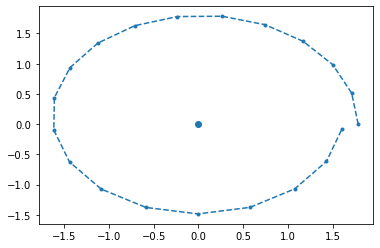

In [14]:
plt.plot(orbit_data_2[:,0],orbit_data_2[:,2],'.--')
plt.scatter([0],[0])
plt.show()

### Solution to (b)

In [15]:
# Initialize our odeint format of newton_3
newton_3_odeint = build_odeint(newton_3)

# Get the correct orbit and time vector
real_orbit_2 = orbit_data_2
t_2 = np.linspace(0,0.05,20)

In [16]:
# Define the loss function
@jit
def loss_2(m_N_est, r_N_est):
    """params should be a vector with the first element being an m_N estimate and the second being an r_N
    estimate"""
    init_conds = np.concatenate((real_orbit_2[0,:], np.array([r_N_est, 0, 0, circle_v(m_S, r_N_est)])))
    return np.sum((newton_3_odeint(init_conds, t_2, m_N_est, r_N_est)[:,[0,2]].reshape(-1)
                   -real_orbit_2[:,[0,2]].reshape(-1))**2)

In [17]:
print(np.arange(8).reshape(1,8))
print(np.arange(8).reshape(1,8)[:,[0,2]])

[[0 1 2 3 4 5 6 7]]
[[0 2]]


In [18]:
# Create a function for performing gradient steps
@jit
def step(i, opt_state):
    # Parameters for the optimisation algorithm
    params = opt_get_params(opt_state)
    
    # Gradient of the loss function
    grad_1 = m_N_grad(params[0], params[1])
    grad_2 = r_N_grad(params[0], params[1])
    #grad_3 = v_N_grad(params[0], params[1], params[2])

    # Update step
    return opt_update(i, np.array([grad_1, grad_2]), opt_state)

In [19]:
# Set up the JAX optimizer
opt_init, opt_update, opt_get_params = optimizers.adagrad(step_size=0.1)

# Get the gradient functions
m_N_grad = jit(grad(loss_2, 0))
r_N_grad = jit(grad(loss_2, 1))
#v_N_grad = jit(grad(loss_2, 2))

In [ ]:
# Create a grid of initial values to try
m_N_est_vec = onp.linspace(5,15,2)
r_N_est_vec = onp.linspace(2,5,2)

best_loss = -1
best_init_params = []
best_final_params = []

for m_N_est in m_N_est_vec:
    for r_N_est in r_N_est_vec:
        
        # Initialize the optimizer
        opt_state = opt_init(np.array([m_N_est, r_N_est]))

        # Perform gradient descent
        for i in range(20):
            opt_state = step(i, opt_state)

        # Final parameters after training
        final_params = opt_get_params(opt_state)
        final_loss = loss_2(final_params[0], final_params[1])

        if best_loss == -1:
            best_loss = final_loss
            best_init_params = np.array([m_N_est, r_N_est])
            best_final_params = final_params

        elif final_loss < best_loss:
            best_loss = final_loss
            best_init_params = np.array([m_N_est, r_N_est])
            best_final_params = final_params

In [ ]:
print(best_init_params)
print(best_final_params)
print(best_loss)

In [ ]:
init_conds_2 = np.concatenate((real_orbit_2[0,:], 
                               np.array([best_final_params[1], 0, 0, circle_v(m_S, best_final_params[1])])))
est_orbit = newton_3_odeint(init_conds_2, t_2, best_final_params[0], best_final_params[1])[:,0:4]

In [ ]:
init_conds_2

In [ ]:
plt.plot(est_orbit[:,0],est_orbit[:,2],'.--')
plt.plot(orbit_data_2[:,0],orbit_data_2[:,2],'.--')
plt.scatter([0],[0])
plt.show()

In [ ]:
best_init_params

In [ ]:
test = np.arange(9).reshape(3,3)
test[[0,2],:]

Report your findings to kaggle!